In [1]:
# reload magic
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from mldec.datasets import toy_problem_data, toric_code_data
from mldec.models import baselines
from mldec.utils import evaluation

#### Toric code tuning analysis: see which hyperparameters were good
 
 - March 22 only-good-examples
    - lr=0.001 was perfect(!) - every model with this learning rate did perfectly
    - d_model >= 16 will be better
    - dim_feedforward 8,16 not good
TO REMOVE:
    - d_model=4,8, dim_feedforward=8,16,lr=0.0001, 0.005
    - dim_feedforward 8,16 not good

In [ ]:
target = "transformer_toric_code_only_good_examples_results.csv"

df = pd.read_csv(target)
# df_cnn = pd.read_csv(target_cnn)


[0.0001 0.0005 0.001  0.002  0.006 ]


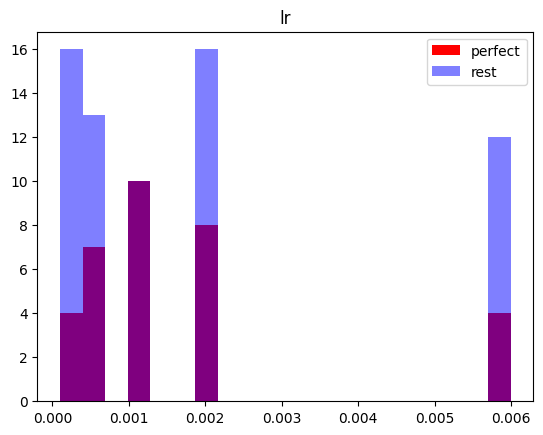

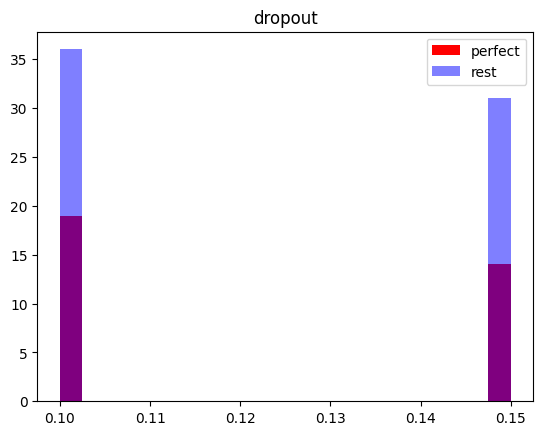

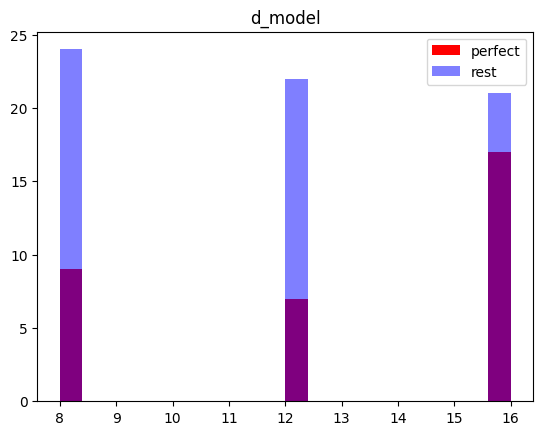

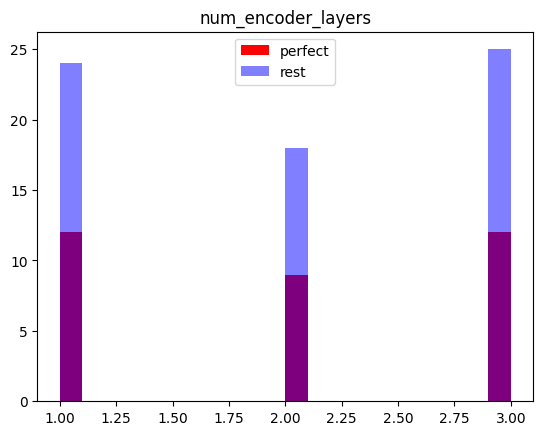

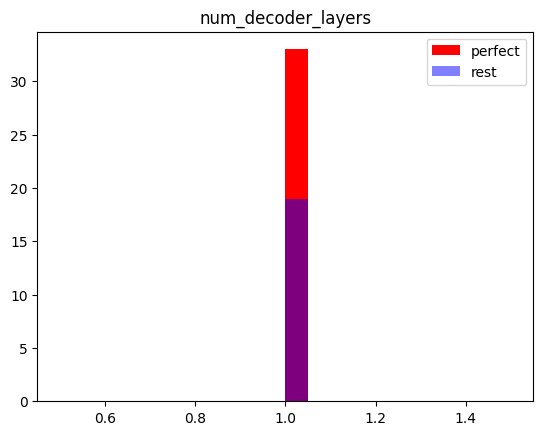

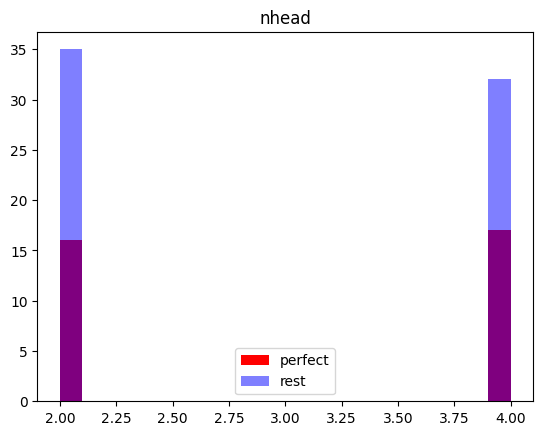

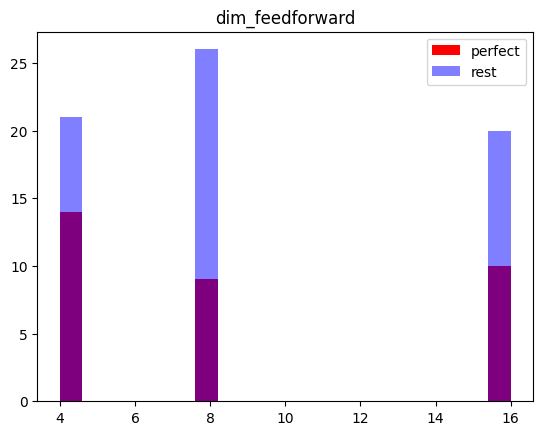

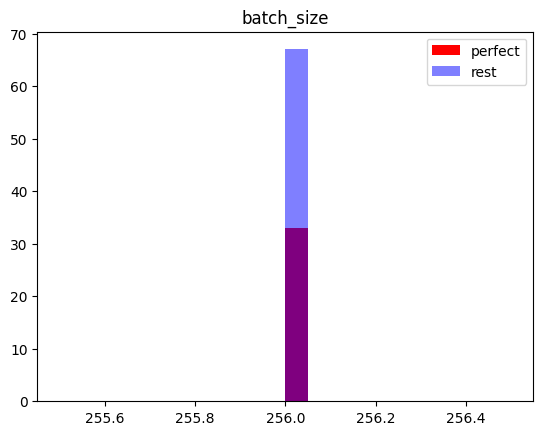

In [8]:
# histogram of 'val_acc' 
# df['val_acc'].hist(bins=20)
def compare_slice_by_column(df, column, slice_by):
    best = df[df[slice_by] == 1]
    other = df[df[slice_by] != 1]
    cts, bins, _ = plt.hist(best[column], bins=20, alpha=1, color='r', label='perfect')
    plt.hist(other[column], bins=bins, alpha=0.5, color='b', label='rest')
    plt.legend()
    plt.title(column)
    plt.show()

for column in ['lr', 'dropout', 'd_model', 'num_encoder_layers', 'num_decoder_layers', 'nhead', 'dim_feedforward', 'batch_size']:
    compare_slice_by_column(df, column, 'val_acc')

## Run analysis

#### Baseline: Weighted MWPM


In [3]:
ptrue = 0.05
var = 0.03
n = 9
dataset_config = {"p": ptrue, "var": var, "beta": 1.0}
X, Y, good_weights = toric_code_data.uniform_over_good_examples(n, dataset_config)
X, Y, val_weights = toric_code_data.create_dataset_training(n, dataset_config)

C:\Users\peter\Desktop\projects\mldec\src\mldec\datasets\toric_code_data.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X, Y, probs = torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32), torch.tensor(probs, dtype=torch.float32)


In [6]:
np.__version__

'1.26.4'

In [16]:
error_probs = toric_code_data.make_variance_noise_model(n, dataset_config, return_probs=True)
print("device qubit errors")
print(error_probs)
for beta in np.linspace(0.75, 3, 10):
    adjusted_probs = error_probs * beta
    adjusted_probs = np.ones(n) * ptrue * beta
    minimum_weight_decoder = baselines.MinimumWeightPerfectMatching()
    minimum_weight_decoder.make_decoder(None, None, error_probs=error_probs)
    minimum_weight_val_acc = evaluation.weighted_accuracy(minimum_weight_decoder, X, Y, val_weights)
    print("minweight acc: {}".format(minimum_weight_val_acc))


device qubit errors
[0.10890275 0.05827309 0.06375975 0.08003794 0.02708494 0.07165783
 0.02283591 0.0800562  0.03437773]
minweight acc: 0.9524514675140381
minweight acc: 0.9524514675140381
minweight acc: 0.9524514675140381
minweight acc: 0.9524514675140381
minweight acc: 0.9524514675140381
minweight acc: 0.9524514675140381
minweight acc: 0.9524514675140381
minweight acc: 0.9524514675140381
minweight acc: 0.9524514675140381
minweight acc: 0.9524514675140381


In [17]:
# compute optimal performance on this dataset .9524514

mld = baselines.LookupTable()
mld.train_on_histogram(X, Y, good_weights)
mld_acc = evaluation.weighted_accuracy(mld, X, Y, val_weights) 
print(f"MLD table accuracy: {mld_acc}")

# compute the MLD for a no-variance depolarizing noise model
mld_for_novar = []
betavals = sorted(df_novar['beta'].unique())
for beta in betavals:
    novar_dataset_config = {"p": ptrue, "var": 0, "beta": beta}
    X, Y, good_weights = toric_code_data.uniform_over_good_examples(n, novar_dataset_config)
    # train an MLD on the no-variance noise model, and then
    # evaluate on the "true" noise profile
    mld_novar = baselines.LookupTable()
    mld.train_on_histogram(X, Y, good_weights)
    acc_novar = evaluation.weighted_accuracy(mld, X, Y, val_weights)
    mld_for_novar.append(acc_novar)
    print(acc_novar)


MLD table accuracy: 0.9636911153793335


C:\Users\peter\Desktop\projects\mldec\src\mldec\models\baselines.py:62: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  return torch.tensor(out)


NameError: name 'df_novar' is not defined

In [20]:
target_var = "toric-code-var-exp-v1/transformer_toric_code_results.csv"
df_var = pd.read_csv(target_var)

target_novar1 = "toric-code-novar-exp-v2/transformer_toric_code_results.csv"
target_novar2 = "toric-code-novar-exp-v2.1/transformer_toric_code_results.csv"
df_novar1 = pd.read_csv(target_novar1)
df_novar2 = pd.read_csv(target_novar2)
# merge dfs
df_novar = pd.concat([df_novar1, df_novar2])

In [55]:
_, _, p_TL_true = toric_code_data.create_dataset_training(n, dataset_config, cache=True)
p_TL_true = p_TL_true.reshape(-1, 2**2).numpy()
true_argmaxes = p_TL_true.argmax(1)
for beta in [3.0]:
    novar_dataset_config = {"p": ptrue, "var": 0, "beta": beta}
    X, Y, p_TL = toric_code_data.create_dataset_training(n, novar_dataset_config, cache=True)
    p_TL = p_TL.reshape(-1, 2**2).numpy()
    fake_argmaxes = p_TL.argmax(1)

# print out where the argmaxes differ
diffs = np.where(true_argmaxes != fake_argmaxes)

for i in diffs[0]:
    print(p_TL_true[i], true_argmaxes[i], p_TL[i], fake_argmaxes[i])


[2.8680058e-04 1.3364481e-05 5.5490265e-04 2.5832151e-05] 2 [0.00097285 0.00012267 0.00097285 0.00012267] 0
[1.4629602e-05 1.6524149e-05 1.6528032e-04 1.8669316e-04] 3 [0.00012267 0.00012267 0.00097285 0.00097285] 2
[2.1464280e-04 5.3174430e-05 2.5929837e-04 2.4934578e-05] 2 [0.0019293  0.00041557 0.00174267 0.00022895] 0
[2.8680058e-04 1.3364481e-05 5.5490265e-04 2.5832151e-05] 2 [0.00097285 0.00012267 0.00097285 0.00012267] 0
[1.5749810e-06 1.6768209e-06 1.5976357e-05 1.6622193e-05] 3 [3.973050e-05 3.973050e-05 2.263545e-04 2.263545e-04] 2
[3.2332691e-04 1.1886761e-05 6.2564627e-04 2.2972539e-05] 2 [0.00097285 0.00012267 0.00097285 0.00012267] 0
[1.2268903e-06 1.4402442e-06 1.8271514e-05 3.1191626e-05] 3 [3.973050e-05 3.973050e-05 2.263545e-04 2.263545e-04] 2
[2.5442891e-05 4.2248015e-05 3.3005944e-04 2.3804145e-04] 2 [0.00022895 0.00041557 0.00174267 0.0019293 ] 3
[8.8089473e-06 2.7962290e-06 1.6585464e-05 5.2517453e-06] 2 [7.47225e-05 7.47225e-05 7.47225e-05 7.47225e-05] 0
[2.17718

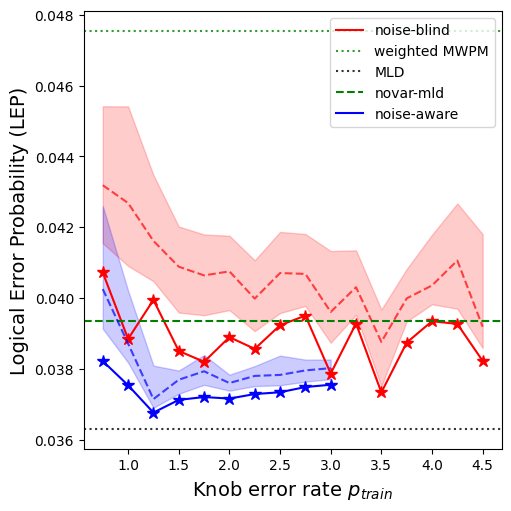

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), sharey=True, constrained_layout=True)

colors = ['r', 'b']
labels = [ 'noise-blind', 'noise-aware']
for jj, df in enumerate([df_novar, df_var]):
    
    color = colors[jj]
    # compute performance/stats on each of the models
    betavals = sorted(df['beta'].unique())
    yerrs_meds = []
    yerrs_mins = []
    yerrs_ub = []
    yerrs_lb = []
    better_than_lookup_arr = [] # track when the model is better than the lookup table
    for i, beta in enumerate(betavals):
        y = df[df['beta'] == beta]['val_acc']
        y_err = 1 - y
        yerrs_meds.append(y_err.median())
        # get 
        # y_ub = y_err.quantile(.75)
        # y_lb = y_err.quantile(0.25)
        y_ub = y_err.quantile(.95)
        y_lb = y_err.quantile(0.05)
        # y_ub = max(y_err)
        # y_lb = min(y_err)
        yerrs_ub.append(y_ub)
        yerrs_lb.append(y_lb)
        yerrs_mins.append(y_err.min())

        # Also get the min weight performance
        vs_minweight = df[df['beta'] == beta]['vs_minweight'].values
        minweight = y - vs_minweight
        min_minweight_err = min(np.round(1 - minweight, 7)) # machine precision errors from the subtraction op above...

        # now, find the comparison of this plot to the lookup table on the plot
        vs_lookup = df[df['beta'] == beta]['vs_lookup'][y.idxmax()]
        better_than_lookup = vs_lookup > 0
        better_than_lookup_arr.append(better_than_lookup)
    
    yerrs_meds = np.array(yerrs_meds)
    yerrs_mins = np.array(yerrs_mins)
    yerrs_ub = np.array(yerrs_ub)
    yerrs_lb = np.array(yerrs_lb)

    # xvals = ptrue * np.array(betavals)
    xvals = np.array(betavals)

    ax.fill_between(xvals, yerrs_lb, yerrs_ub, color=color, alpha=0.2)
    ax.plot(xvals, yerrs_meds, ls='--', marker=None, c=color, alpha=0.7)
    ax.plot(xvals, yerrs_mins, ls='-', marker=None, c=color, label=labels[jj])
    # wherever the result is better than lookup, plot a star
    for i, beta in enumerate(betavals):
        if better_than_lookup_arr[i]:
            marker = '*'
            markersize = 9
        else:
            marker = 'o'
            markersize = 6
        ax.plot(xvals[i], yerrs_mins[i], marker=marker, c=color, markersize=markersize)

    ax.set_xlabel(r"Knob error rate $p_{train}$", size=14)
    if jj ==0:
        ax.axhline(min_minweight_err, ls=':', c='g', alpha=0.8, label='weighted MWPM')
        ax.axhline(1 - mld_acc, ls=':', c='k', alpha=0.8, label='MLD')
        ax.axhline(1 - 0.96064, ls='--', label='novar-mld', c='g')

# axes[0].set_ylim([9e-4, 2e-1])
ax.set_ylabel("Logical Error Probability (LEP)", size=14)
ax.legend(loc="upper right")
    
fig.savefig(f"../../figures/agg_toric_code.pdf", bbox_inches='tight')

Issues:
 - variance looks really small..?
 - what the fuck is the phase-looking stuff

brainstorming these issues:
  - what changes between beta=1.75 to beta=2? the training dataset gets 'noisier', best train score decreases, but (apparently!) the MLD trained on the no-var training set (and then applied to the var evaluation set) is always the same regardless of beta??
  - N=10000 but my clustering is still pretty tight around the median (best) validation acc! 150 trials means 150 chances to get some surprisingly good best-validation-acc, but the (best) validation accs for models trained on beta=2 are CONSISTENTLY better than the best validation accs for models trained on beta=1.75. 
IDEA: If I seeded in the toric_code_data, this might get passed directly on to the training set sampling, i.e. my training set gets sampled identically. I need to get rid of that seed!